<a href="https://colab.research.google.com/github/neeleshbisht99/RemoteSensingImageClassification/blob/master/undergrad_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prerequisites**

*   1   --> Forest
*   2  --> Water
*   3 --> Herbaceous
*   4 --> Barren
*   5 --> Urban


**Importing training data**

In [8]:
from __future__ import print_function
from osgeo import ogr, gdal

training_dataset = ogr.Open('training_data.shp',0)
layer = training_dataset.GetLayerByIndex(0)
print('The layer is named: {n}\n'.format(n=layer.GetName()))


The layer is named: training_data



**Rasterizing Shape File**

In [9]:
raster_ds = gdal.Open('LE70220491999322EDC01_stack.gtif', gdal.GA_ReadOnly)

ncol = raster_ds.RasterXSize
nrow = raster_ds.RasterYSize

# Fetch projection and extent
proj = raster_ds.GetProjectionRef()
ext = raster_ds.GetGeoTransform()

raster_ds = None

memory_driver = gdal.GetDriverByName('GTiff')
out_raster_ds = memory_driver.Create('./training_data.gtif', ncol, nrow, 1, gdal.GDT_Byte)

out_raster_ds.SetProjection(proj)
out_raster_ds.SetGeoTransform(ext)

b = out_raster_ds.GetRasterBand(1)
b.Fill(0)

status = gdal.RasterizeLayer(out_raster_ds,  # output to our new dataset
                             [1],  # output to our new dataset's first band
                             layer,  # rasterize this layer
                             None, None,  # don't worry about transformations since we're in same projection
                             [0],  # burn value 0
                             ['ALL_TOUCHED=TRUE',  # rasterize all pixels touched by polygons
                              'ATTRIBUTE=id']  # put raster values according to the 'id' field values
                             )

out_raster_ds = None

if status != 0:
    print("I don't think it worked...")
else:
    print("Success")

Success


**Assess the training data formed by rasterizing vector data(shape file)**

In [10]:
import sys
import numpy as np

roi_ds = gdal.Open('./training_data.gtif', gdal.GA_ReadOnly)
roi = roi_ds.GetRasterBand(1).ReadAsArray()
print(roi)

classes = np.unique(roi)

for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Class 0 contains 61400 pixels
Class 1 contains 583 pixels
Class 2 contains 24 pixels
Class 3 contains 223 pixels
Class 4 contains 173 pixels
Class 5 contains 97 pixels


**Creating 3D array from gtif file**

In [11]:
from __future__ import division
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
# np.set_printoptions(threshold=sys.maxsize)


gdal.UseExceptions()
gdal.AllRegister()

img_ds = gdal.Open('LE70220491999322EDC01_stack.gtif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('training_data.gtif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)


print(img.shape)
print(roi.shape)

#Display them
# plt.subplot(121)
# plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
# plt.title('SWIR1')

# plt.subplot(122)
# plt.imshow(roi, cmap=plt.cm.Spectral)
# plt.title('ROI Training Data')

# plt.show()



(250, 250, 8)
(250, 250)


**Transforming 3D array to 2D aray, in order to create training data**

In [12]:
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

## training data here 2D array of pixels and corresponding 8 bands
X = img[roi > 0, :]  

y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

clear = X[:, 7] <= 1

X = X[clear, :7]  # we can ditch the Fmask band now
y = y[clear]

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))



We have 1100 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (1100, 8)
Our y array is sized: (1100,)
After masking, our X matrix is sized: (1100, 7)
After masking, our y array is sized: (1100,)


**Training random forest model**

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)
                          
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

bands = [1, 2, 3, 4, 5, 7, 6]
for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))
    

Our OOB prediction of accuracy is: 98.72727272727273%
Band 1 importance: 0.13280120280858362
Band 2 importance: 0.1945773723959226
Band 3 importance: 0.10443841511734424
Band 4 importance: 0.10491275669775825
Band 5 importance: 0.2184575269645303
Band 7 importance: 0.15637191864406927
Band 6 importance: 0.08844080737179187


**Testing the model**

In [21]:

new_shape = (img.shape[0] * img.shape[1], img.shape[2] - 1)

img_as_array = img[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))


class_prediction = rf.predict(img_as_array)

print(class_prediction.shape)
print("reshape")

class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print(class_prediction.shape)

classes = np.unique(class_prediction)

## total pixels inside a class
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(class_prediction == c).sum()))

Reshaped from (250, 250, 8) to (62500, 7)
(62500,)
reshape
(250, 250)
Class 1 contains 24171 pixels
Class 2 contains 602 pixels
Class 3 contains 28408 pixels
Class 4 contains 8792 pixels
Class 5 contains 527 pixels


**Classification matrix on training data**

In [15]:
import pandas as pd

df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict    1   2    3    4   5   All
truth                               
1        583   0    0    0   0   583
2          0  24    0    0   0    24
3          0   0  223    0   0   223
4          0   0    0  173   0   173
5          0   0    0    0  97    97
All      583  24  223  173  97  1100


**Visualizing the result**

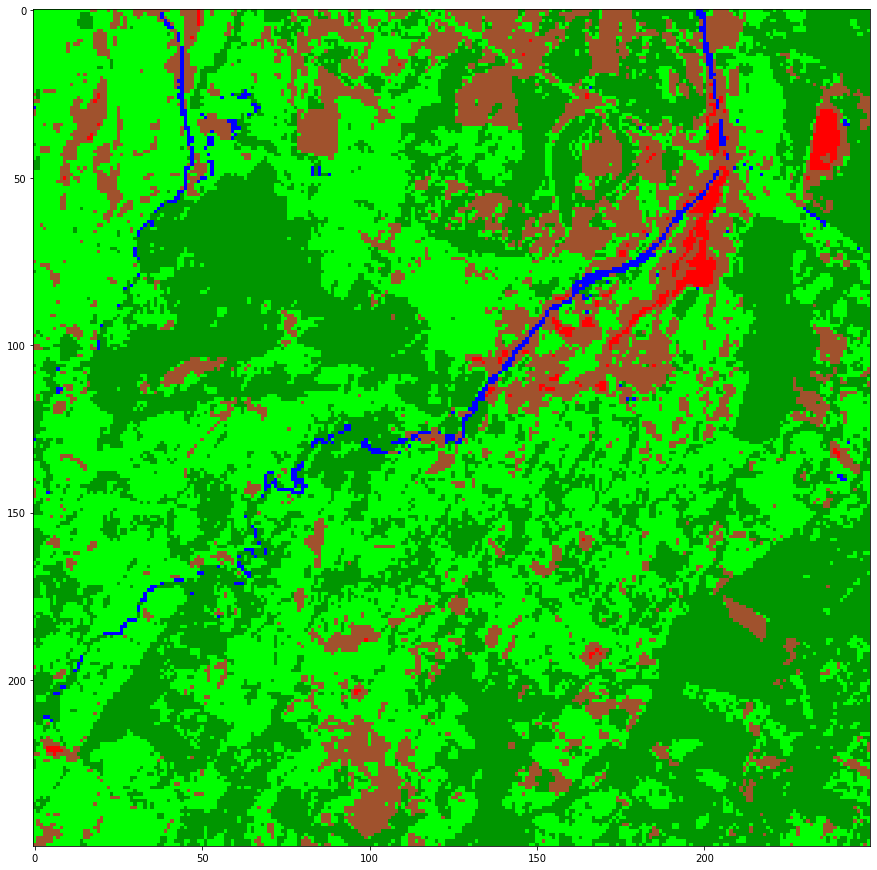

In [20]:
n = class_prediction.max()

colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (0, 150, 0, 255)),  # Forest
    (2, (0, 0, 255, 255)),  # Water
    (3, (0, 255, 0, 255)),  # Herbaceous
    (4, (160, 82, 45, 255)),  # Barren
    (5, (255, 0, 0, 255))  # Urban
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v

index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', int(n))

plt.figure(figsize=(33,33))
plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.show()

